In [2]:
!pip install python-Levenshtein

EXAMPLE_FIELDS = {'SalarySlip': ['Deduction-1-Description','IncomeBeforeTax','DateOfBirth'], 
                  'PersonalPensionOverview': ['CitizenServiceNumber', 'RetirementAge'],
                  }

NR_OF_DOCS = 5

# 'EmployerStatement' gives an error
# 'BankStatement','Passport','IdentityCard' no OCR output

# BalStat returns no matches
# 'BalanceStatementResidualDebt': ['AccountHolder-1-Surname', 'Year'],

#Does not really work well with contract types
#                  'AppraisalReport': ['LandRegistration-1-Municipality','EnergyLabel'],
#                  'PurchaseAgreement': ['Buyer-1-Surname', 'Address-City'],


     |████████████████████████████████| 48 kB 5.9 MB/s  eta 0:00:01
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.0-cp36-cp36m-linux_x86_64.whl size=151468 sha256=674dd0102498bc5e2d55aff82e6cb9f910cf4a54f859cb35efc26c115f34796b
  Stored in directory: /home/ec2-user/.cache/pip/wheels/79/c3/a1/cbdd8b154234b3e571d121b65be7d53354cc77e223e8f271c8
Successfully built python-Levenshtein
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow_p36/bin/python -m pip install --upgrade pip' command.


In [19]:
from docstreet import get_documents, find_values_in_abbyy_output, detect_field_types
from lowresdocmatrix import LowResDocMatrixGenerator, get_content_in_matrix_area, get_middle_cell_in_area
from collections import Counter
    
def show_relations(relations):
    
    for ((content,distance), freq) in relations:
        print(f'  * {content} at {distance} ({freq}x)')
    
for doctype in EXAMPLE_FIELDS.keys():
    docs = get_documents(max_docs=NR_OF_DOCS,document_type=doctype,repair_widget_output_available=True,load_repair_widget_output=True,
                         dta_output_available=True,load_dta_output=True,
                     ocr_output_available=True,load_ocr_output=True)
    
    field_types = detect_field_types(docs)
    
    gen = LowResDocMatrixGenerator()
    gen.fit([doc.ocr_output for doc in docs])
    matrices = gen.calculate_matrices([doc.ocr_output for doc in docs])    

    for field in EXAMPLE_FIELDS[doctype]:
        relations_in_row = Counter()
        relations_in_column = Counter()
        relations_at_full_distance = Counter()
        relations_at_horizontal_distance = Counter()
        relations_at_vertical_distance = Counter()

        print(doctype,field)
        
        for doc,matrix in zip(docs, matrices):   
            matches = find_values_in_abbyy_output(doc.ocr_output,doc.repair_widget_output_unmapped,field_types)
            
            if field not in matches.keys():
                continue
            
            for match in matches[field]:
                x_in_focus, y_in_focus = get_middle_cell_in_area(matrix,match.left,match.right,match.top,match.bottom)
                    
                for x in range(matrix.matrix.shape[1]):
                    for y in range(matrix.matrix.shape[0]):
                        
                        content = matrix.matrix[y,x]
                        if content == 0: #dont look at empty cells
                            continue
                        
                        content = gen.index_to_word[content]
                                                                        
                        horizontal_distance = abs(x_in_focus-x)
                        vertical_distance = abs(y_in_focus-y)
                        full_distance = (horizontal_distance,vertical_distance)
                                                
                        relations_at_full_distance[(content,full_distance)] += 1
                        relations_at_horizontal_distance[(content,horizontal_distance)] += 1
                        relations_at_vertical_distance[(content,vertical_distance)] += 1
                        
                        if horizontal_distance == 0:
                            relations_in_row[(content,0)] += 1
                            
                        if vertical_distance == 0:
                            relations_in_column[(content,0)] += 1
        
        print('* full distance')
        show_relations(relations_at_full_distance.most_common(10))

        print('* horizontal distance')
        show_relations(relations_at_horizontal_distance.most_common(10))        

        print('* vertical distance')
        show_relations(relations_at_vertical_distance.most_common(10)) 

        print('* in row')
        show_relations(relations_at_vertical_distance.most_common(10)) 

        print('* in column')
        show_relations(relations_at_vertical_distance.most_common(10)) 
        
        print()

SalarySlip Deduction-1-Description
* full distance
  * Pensioenpremie at (1, 0) (3x)
  * 9999.aa.aaaaaaaa at (2, 8) (2x)
  * aa99aaa99999999999 at (2, 6) (2x)
  * aaaaaaa.aaaaaaaa.aaaa.aa.aa at (2, 2) (2x)
  * aaa.aaaaaaaaaa..aaaa. at (2, 1) (2x)
  * Pensioenpremie at (2, 0) (2x)
  * aaa.aaaaaaaaaaaaaaaa at (2, 1) (2x)
  * Sub-totaal Vaste beloningen at (2, 2) (2x)
  * aaaaaaaaaaaaaaaaaaaa.aaaa.aaaa at (2, 3) (2x)
  * Sub-totaal Onbelaste beloningen at (2, 4) (2x)
* horizontal distance
  * aaaaaaaaaaaa at 1 (7x)
  * aaaaaaaaaaaaaaaaaaa at 9 (5x)
  * aaaaaaaaaaaaaaaaaaa at 10 (5x)
  * over at 12 (5x)
  * over at 13 (5x)
  * aaaaaaaaaaaaa.99 at 1 (4x)
  * Pensioenpremie at 1 (4x)
  * aaaaaaaaa.aaaaaaaa at 2 (4x)
  * aaaaaaaaa.aaaaaaaa at 1 (4x)
  * aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa.aaaaa at 1 (4x)
* vertical distance
  * aaa..aaaaaaaaaaa..9999.99 at 15 (11x)
  * aaaaaaaaa.999.99 at 16 (10x)
  * aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa at 5 (9x)
  * aaaaaaaaaaaaaaaaaaaaaaaa

In [15]:
from IPython.display import display
from PIL import Image

from docstreet import get_documents, find_values_in_abbyy_output, detect_field_types
from lowresdocmatrix import LowResDocMatrixGenerator, get_content_in_matrix_area, get_middle_cell_in_area
from collections import Counter
from math import sqrt

class PositionalCluster():
    
    def __init__(self,word = None,position = None, document_id = None):
        
        self.positions = Counter()
        
        if position != None:
            self.positions[position] = 1

        self.words = []
        
        if word != None:
            self.words.append(word)
    
        self.document_ids = []
        
        if document_id != None:
            self.document_ids.append(document_id)
    
    def fits(self,word,new_position,distance_threshold = 1):
        
        if word not in self.words:
            return False
        
        for existing_position in self.positions.keys():
            distance = sqrt((existing_position[0]-new_position[0])**2 + (existing_position[1]-new_position[1])**2)
            if distance <= distance_threshold:
                return True
            
    def add(self,word,position,document_id = None):
        
        if word not in self.words:
            self.words.append(word)
        
        self.positions[position] += 1
        
        if document_id != None and document_id not in self.document_ids:
            self.document_ids.append(document_id)
        
    def __repr__(self):
        return f'<Cluster {self.frequency}*{self.words[0]} {self.positions}>'
        
    @property
    def size(self):
        return sum(self.positions.values())
    
    @property
    def frequency(self):
        return len(self.document_ids)
        
def merge_clusters(clusters):
    
    result = PositionalCluster()
    #result.words = [word for cluster in clusters for word in cluster]
    result.words = list(set(sum([cluster.words for cluster in clusters],[])))
    result.document_ids = list(set(sum([cluster.document_ids for cluster in clusters],[])))
    result.positions = sum([cluster.positions for cluster in clusters],Counter())
    return result
    
def find_relations(matrices,focus_cells,index_to_word, top_n = 5):

    relations_in_row = Counter()
    relations_in_column = Counter()
    relations_at_full_distance = Counter()
    relations_at_horizontal_distance = Counter()
    relations_at_vertical_distance = Counter()  
    positional_clusters = []
    
    for n, matrix in enumerate(matrices):
        
        for y in range(matrix.matrix.shape[1]):            
            for x in range(matrix.matrix.shape[0]):

                content = matrix.matrix[x,y]
                if content == 0: #dont look at empty cells
                    continue

                content = index_to_word[content]

                for y_in_focus, x_in_focus in focus_cells[n]:
                    horizontal_distance = x-x_in_focus
                    vertical_distance = y-y_in_focus
                                        
                    full_distance = (horizontal_distance,vertical_distance)

                    relations_at_full_distance[(content,full_distance)] += 1
                    relations_at_horizontal_distance[(content,horizontal_distance)] += 1
                    relations_at_vertical_distance[(content,vertical_distance)] += 1

                    if horizontal_distance == 0:
                        relations_in_row[(content,0)] += 1

                    if vertical_distance == 0:
                        relations_in_column[(content,0)] += 1

                    matching_clusters = []
                    
                    for cluster in positional_clusters:
                        if cluster.fits(content,(vertical_distance,horizontal_distance)):
                            matching_clusters.append(cluster)
                    
                    if len(matching_clusters) == 0:
                        positional_clusters.append(PositionalCluster(content,(vertical_distance,horizontal_distance),n))
                    elif len(matching_clusters) == 1:
                        matching_clusters[0].add(content,(vertical_distance,horizontal_distance),n)
                    else:
                        combined_cluster = merge_clusters(matching_clusters)
                        
                        for old_cluster in matching_clusters:
                            positional_clusters.remove(old_cluster)
    
                        positional_clusters.append(combined_cluster)
    
    print('Row: ',', '.join([r[0] for r,freq in relations_in_row.most_common(top_n)]))
    print('Column: ',', '.join([r[0] for r,freq in relations_in_column.most_common(top_n)]))
    print('Full distance: ',', '.join([r[0] for r,freq in relations_at_full_distance.most_common(top_n)]))

    positional_clusters = sorted(positional_clusters,key=lambda cluster: cluster.frequency,reverse=True)    

    return positional_clusters
    
def visualize_matrix(matrix,highlight_positions=None,highlight_content=None,word_to_index_dictionary=None):
    
    print(highlight_positions)
    content_index = word_to_index_dictionary[highlight_content]
    
    shape = matrix.matrix.shape
    image = Image.new('RGB',(shape[1],shape[0]))
    for x in range(shape[1]):
        for y in range(shape[0]):
            
            if (x,y) in highlight_positions:
                color = (255,0,0)
            elif matrix.matrix[y,x] == content_index:
                color = (0,255,0)
            else:
                color = (0,0,0)
            
            image.putpixel((x,y),color)

    image = image.resize((shape[1]*10,shape[0]*10))
    display(image)

DOCTYPE = 'PersonalPensionOverview'
FIELD = 'CitizenServiceNumber'    
NR_OF_DOCS = 50

docs = get_documents(max_docs=NR_OF_DOCS,document_type=DOCTYPE,repair_widget_output_available=True,load_repair_widget_output=True,
                     dta_output_available=True,load_dta_output=True,
                 ocr_output_available=True,load_ocr_output=True)

field_types = detect_field_types(docs)

gen = LowResDocMatrixGenerator()
gen.fit([doc.ocr_output for doc in docs])
matrices = gen.calculate_matrices([doc.ocr_output for doc in docs])

focus_cells_per_doc = []

for doc, matrix in zip(docs,matrices):

    matches = find_values_in_abbyy_output(doc.ocr_output,doc.repair_widget_output_unmapped,field_types)

    if FIELD not in matches.keys():
        continue

    matching_cells = []

    for match in matches[FIELD]:
        focus_cells = matrix.get_cells_overlapping_with_area(match.left,match.right,match.top,match.bottom)[0]
        matching_cells += focus_cells
    
    focus_cells_per_doc.append(matching_cells)

    #visualize_matrix(matrix,matching_cells,'Geboortedatum',gen.word_to_index)

positional_clusters = find_relations(matrices,focus_cells_per_doc,gen.index_to_word, top_n = 10)

Row:  999999999, aaa..a.a.a.a..aaaa, BSN:, aaa..a.a..aaa.aaa.aaaaa, aaa..aa.a..aaaaaaa, aaa..a.a.a..aaaaaaaaa, aaa..a.a..aaaa, aaaa..a..aaaaaa
Column:  Sociale Verzekeringsbank, Alle genoemde bedragen zijn bruto bedragen in euro's per jaar., Pensioen bij overlijden, Pensioen bij pensionering, Wat ontvangen mijn partner en kinderen als ik overlijd?, 01, Uw te bereiken pensioen wordt verlaagd met het bedrag dat in de kolom 'voor ex-partner' staat. Is het bedrag in de kolom 'voor ex-, Uw pensioengegevens in dit overzicht zijn verstrekt door de Sociale Verzekeringsbank en uw pensioenuitvoerder(s). Lees altijd de, voor dit pensioen aparte afspraken maakte met uw ex-partner, waardoor de scheiding geen effect heeft op dit pensioen., De leeftijden die u in dit overzicht ziet, zijn de leeftijden van uw partner en/of uw kind(eren).
Full distance:  Alle genoemde bedragen zijn bruto bedragen in euro's per jaar., Alle genoemde bedragen zijn bruto bedragen in euro's per jaar., Alle genoemde bedragen

Uw pensioengegevens in dit overzicht zijn verstrekt door de Sociale Verzekeringsbank en uw pensioenuitvoerder(s). Lees altijd de


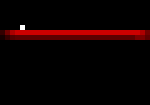

ontlenen.


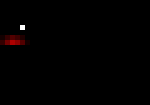

Pensioen bij pensionering


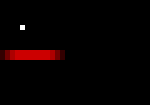

informatie die u van hen ontvangt. Hierin staat belangrijke persoonlijke informatie. Aan deze samenvatting kunt u geen rechten


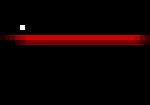

Stand per


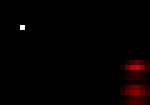

01


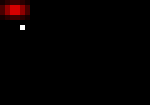

BSN:


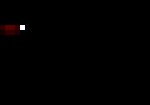

Alle genoemde bedragen zijn bruto bedragen in euro's per jaar.


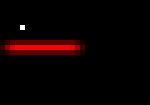

999999999


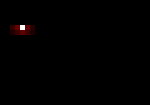

Herkenningsnummer


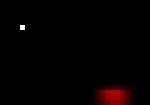

In [16]:
from IPython.display import display
from PIL import Image

def visualize_positional_clusters(positional_clusters):
    x_values = []
    y_values = []
    frequencies = []

    for cluster in positional_clusters:
        for position, freq in cluster.positions.items():
            x_values.append(position[0])
            y_values.append(position[1])
            frequencies.append(freq)

    largest_x = max(x_values)
    smallest_x = min(x_values)
    largest_y = max(y_values)
    smallest_y = min(y_values)
    largest_freq = 25

    x_size = largest_x - smallest_x
    y_size = largest_y - smallest_y
    zero_position = (-smallest_x,-smallest_y)

    images = []
    
    for cluster in positional_clusters:
        image = Image.new('RGB',(x_size,y_size))
        for x in range(x_size):
            for y in range(y_size):

                if (x,y) == zero_position:
                    image.putpixel((x,y),(255,255,255))
                else:
                    relative_position = (x-zero_position[0],y-zero_position[1])

                    if relative_position in cluster.positions.keys():
                        color_intensity = cluster.positions[relative_position]/largest_freq

                        if color_intensity > 1:
                            color_intensity = 1

                        image.putpixel((x,y),(round(255*(color_intensity)),0,0))
                    else:
                        image.putpixel((x,y),(0,0,0))            

        image = image.resize((x_size*5,y_size*5))
        images.append(image)
        
    return images
        
images = visualize_positional_clusters(positional_clusters[:10])

for n, (cluster, image) in enumerate(zip(positional_clusters[:10],images)):
    content = cluster.words[0]
    print(content)
    display(image)
    image.save(f'output/{n}_{content}.png')

Experiment: funnel

In [7]:
from docstreet import get_documents, detect_field_types, find_values_in_abbyy_output

DOCTYPE = 'PersonalPensionOverview'
FIELD = 'RetirementAge'
NR_OF_DOCS = 1000

documents = get_documents(dta_output_available=True,max_docs=NR_OF_DOCS,document_type=DOCTYPE,load_ocr_output=True,load_dta_output=True,
                          load_repair_widget_output=True)
print(len(documents),'initial docs')

docs_with_dta = []
for doc in documents:
    if doc.dta_output_available:
        docs_with_dta.append(doc)
print(len(docs_with_dta),'docs with dta')        

docs_with_field_detected = []
for doc in docs_with_dta:
    if FIELD in doc.dta_output.keys():
        docs_with_field_detected.append(doc)
print(len(docs_with_field_detected),'docs with field detected')

docs_with_ocr = []
for doc in docs_with_field_detected:
    if doc.ocr_output_available:
        docs_with_ocr.append(doc)
print(len(docs_with_ocr),'docs with ocr')

docs_with_rw = []
for doc in docs_with_ocr:
    if doc.repair_widget_output_available:
        docs_with_rw.append(doc)
print(len(docs_with_rw),'docs with rw')

docs_with_field_corrected = []
for doc in docs_with_rw:
    if FIELD in doc.repair_widget_output_unmapped.keys():
        docs_with_field_corrected.append(doc)
print(len(docs_with_field_corrected),'docs with field corrected')

docs_with_match_in_ocr = []
field_types = detect_field_types(docs_with_field_corrected)
for doc in docs_with_field_corrected:
    matches = find_values_in_abbyy_output(doc.ocr_output,doc.repair_widget_output_unmapped,field_types)
    if FIELD in matches.keys():
        docs_with_match_in_ocr.append(doc)
print(len(docs_with_match_in_ocr),'docs with match in ocr')

61 initial docs
61 docs with dta
56 docs with field detected
17 docs with ocr
17 docs with rw
17 docs with field corrected
17 docs with match in ocr


Experiment: find good fields

In [1]:
from docstreet import get_documents, detect_field_types, find_values_in_abbyy_output
from itertools import combinations
from collections import Counter

DOCTYPE = 'SalarySlip'
NR_OF_DOCS = 1000
COMBINATION_SIZE = 3

docs = get_documents(ocr_output_available=True,repair_widget_output_available=True,max_docs=NR_OF_DOCS,document_type=DOCTYPE,
                     load_ocr_output=True,load_repair_widget_output=True)
field_types = detect_field_types(docs)

c = Counter()      

for doc in docs:
    matches = find_values_in_abbyy_output(doc.ocr_output,doc.repair_widget_output_unmapped,field_types)
    
    cleaned_matches = []
    for matching_field, matches in matches.items():        
        if len(matches) > 0 and doc.repair_widget_output_unmapped[matching_field] not in [None,'']:
            cleaned_matches.append(matching_field)
    
    for combination in combinations(cleaned_matches,COMBINATION_SIZE):
        c[combination] += 1
            
print(c.most_common(50))

Initials FieldType.date 0.0 0.0 False False
Initials FieldType.percentage 0.0 0.0 False False
Initials FieldType.money 0.0 0.0 False False
Surname FieldType.date 0.0 0.0 False False
Surname FieldType.percentage 0.0 0.0 False False
Surname FieldType.money 0.0 0.0 False False
Gender FieldType.date 0.0 0.0 False False
Gender FieldType.percentage 0.0 0.0 False False
Gender FieldType.money 0.0 0.0 False False
Address-Street FieldType.date 0.0 0.0 False False
Address-Street FieldType.percentage 0.0 0.0 False False
Address-Street FieldType.money 0.0 0.0 False False
Address-PostalCode FieldType.date 0.0 0.0 False False
Address-PostalCode FieldType.percentage 0.0 0.0 False False
Address-PostalCode FieldType.money 0.0 0.0 False False
Address-City FieldType.date 0.0 0.0 False False
Address-City FieldType.percentage 0.0 0.0 False False
Address-City FieldType.money 0.0 0.0 False False
Name FieldType.date 0.0 0.0 False False
Name FieldType.percentage 0.0 0.0 False False
Name FieldType.money 0.0 0.0 

In [13]:
from docstreet import get_documents, detect_field_types, find_values_in_abbyy_output
from lowresdocmatrix import LowResDocMatrixGenerator, get_content_in_matrix_area, get_cell_coordinates_for_match
from itertools import combinations
from collections import Counter
from json import dumps
from numpy import zeros

DOCTYPE = 'SalarySlip'
FIELDS = ['DateOfBirth','Surname','Address-City']
NR_OF_DOCS = 10000

print('Loading docs')
docs = get_documents(ocr_output_available=True,repair_widget_output_available=True,document_type=DOCTYPE,
                     load_ocr_output=True,load_repair_widget_output=True,max_docs=NR_OF_DOCS)

print('Detecting field types')
field_types = detect_field_types(docs)
print(field_types)

final_docs = []
matches_per_doc = []

print('Finding matches')
for n, doc in enumerate(docs):
    
    if n%100 == 0:
        print(n)
    
    matches = find_values_in_abbyy_output(doc.ocr_output,doc.repair_widget_output_unmapped,field_types)
    found_all = True
    
    for field in FIELDS:
        #print(field in matches.keys(), len(matches[field]), doc.repair_widget_output_unmapped[field])
        #value = doc.repair_widget_output_unmapped[field]

        if field not in matches.keys() or len(matches[field]) == 0:
            found_all = False
                
    if not found_all:
        continue
        
    final_docs.append(doc.ocr_output)
    matches_per_doc.append(matches)

print('Fitting matrix gen')
gen = LowResDocMatrixGenerator()
gen.fit(final_docs)

print('Calculating matrices')
matrices = gen.calculate_matrices(final_docs,verbose=True)

instance_file = open('train_instances','w')
target_file = open('train_target','w')

print('Writing matrices and constructing target')

for matrix_index, (matrix, matches) in enumerate(zip(matrices,matches_per_doc)):

    if matrix_index == 4000:
        
        instance_file = open('test_instances','w')
        target_file = open('test_target','w')
        
    #Build the target matrix
    target = zeros(matrix.matrix.shape)
    found_all_fields = True
    
    for class_index,field in enumerate(FIELDS):
        
        found_something = False
        
        for match in matches[field]:
            cell_coordinates = get_cell_coordinates_for_match(matrix,match,gen.word_to_index)
            
            for (x,y) in cell_coordinates:
                target[x,y] = class_index+1
                found_something = True
                    
        if not found_something:
            found_all_fields = False
            break            

    if not found_all_fields:
        continue
    
    instance_file.write(dumps(matrix.matrix.tolist())+'\n')            
    target_file.write(dumps(target.tolist())+'\n')    

Loading docs
Detecting field types
Initials FieldType.date 0.0 0.0 False False
Initials FieldType.percentage 0.0 0.0 False False
Initials FieldType.money 0.0 0.0 False False
Surname FieldType.date 0.0 0.0 False False
Surname FieldType.percentage 0.0 0.0 False False
Surname FieldType.money 0.0 0.0 False False
Gender FieldType.date 0.0 0.0 False False
Gender FieldType.percentage 0.0 0.0 False False
Gender FieldType.money 0.0 0.0 False False
Address-Street FieldType.date 0.0 0.0 False False
Address-Street FieldType.percentage 0.0 0.0 False False
Address-Street FieldType.money 0.0 0.0 False False
Address-PostalCode FieldType.date 0.0 0.0 False False
Address-PostalCode FieldType.percentage 0.0 0.0 False False
Address-PostalCode FieldType.money 0.0 0.0 False False
Address-City FieldType.date 0.0 0.0 False False
Address-City FieldType.percentage 0.0 0.0 False False
Address-City FieldType.money 0.0 0.0 False False
Name FieldType.date 0.0 0.0 False False
Name FieldType.percentage 0.0 0.0 False 